1. Überprüfen ob "Description" und "Text" der Artikel deckungsgleich sind und gegebenenfalls die betroffenen Artikel entfernen.
2. Nicht-lateinische Schrift entfernen und prüfen ob Heuristiken zur gezielten Entfernung von nicht-deutscher Sprache gefunden werden können (z.B. Originaltitel von Filmen in Klammern hinter dem Artikelnamen)
3. Mindestlänge von Artikeln auf 100 Wörter und Maximallänge auf 2000 Wörter festlegen. Artikel die weniger als 100 Wörter enthalten, werden entfernt und durch längere ersetzt. Artikel mit mehr als 2000 Wörtern werden an der Obergrenze abgeschnitten.
4. Überlappungen zwischen den verschiedenen Datensätzen vor dem Merge prüfen.

In [1]:
import pandas as pd
import collections
import json
import regex

%matplotlib inline

In [2]:
categories = pd.read_csv("../data/kategorien.csv")

### 1. description == text

In [3]:
c = collections.Counter()

for category in categories[categories["description"] == categories["text"]]["category"]:
    c.update([category])

c

Counter({'Krankheit': 29, 'Soziologie': 28})

In [5]:
categories = categories[categories["description"] != categories["text"]].reset_index(drop=True)

### 2. Nicht-lateinische Schrift

In [6]:
token_pattern = regex.compile(r"\p{Letter}+\p{Connector_Punctuation}?\p{Letter}+|\p{Number}+")
nonlatin_pattern = regex.compile(r"\P{InBasic_Latin}")

In [7]:
example = """Deutsch: lateinisches Alphabet, 
             Amharisch: የላቲን አልፋቤት,
             Bengalisch: লাতিন বর্ণমালা,
             Arabisch: اَللُّغَةُ اَلْعَرَبِيَّة,
             Chinesisch: 漢字,
             Japanisch: 日本語"""
" ".join(nonlatin_pattern.findall(example))

'የ ላ ቲ ን አ ል ፋ ቤ ት ল া ত ি ন ব র ্ ণ ম া ল া ا َ ل ل ُ ّ غ َ ة ُ ا َ ل ْ ع َ ر َ ب ِ ي َ ّ ة 漢 字 日 本 語'

In [8]:
foreign = list()

for article in categories["text"]:
    for token in token_pattern.findall(str(article)):
        match = nonlatin_pattern.findall(token)
        if match\
        and "ä" not in token\
        and "ö" not in token\
        and "ü" not in token\
        and "Ä" not in token\
        and "Ö" not in token\
        and "Ü" not in token\
        and "ß" not in token:
            foreign.append(token)

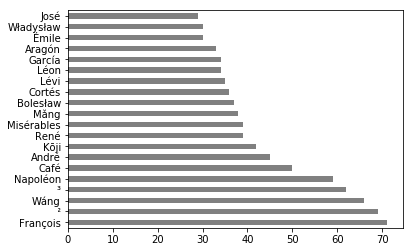

In [9]:
pd.Series(foreign).value_counts()[:20].plot.barh(color="grey")

In [10]:
def drop_nonlatin(articles):
    latin = list()
    for text in articles:
        for token in foreign:
            text = str(text).replace(token, "")
        latin.append(text)
    return latin

In [11]:
categories["description"] = drop_nonlatin(categories["description"])
categories["text"] = drop_nonlatin(categories["text"])

### 3. Mindest- bzw. Maximallänge

In [12]:
minimum = 100
maximum = 2000

In [13]:
length = list()

for article in categories["text"]:
    tokens = token_pattern.findall(article)
    length.append(len(tokens))

categories["length"] = length

In [14]:
categories.head(5)

,category,description,text,length
0,Herrscher,"Adaloald (auch Adalwald, Adulubaldus; * 602 in...","Adaloald (auch Adalwald, Adulubaldus; * 602 in...",236
1,Herrscher,"(auch Aelfwine, Elfwine, Aelfuini, Aelfwinus,...","(auch Aelfwine, Elfwine, Aelfuini, Aelfwinus,...",265
2,Herrscher,(auch: Aescwine; Escuuine) († 676) war von 67...,(auch: Aescwine; Escuuine) († 676) war von 67...,129
3,Herrscher,"I. (auch , , Aedilberct, , oder Ethelbert) (...","I. (auch , , Aedilberct, , oder Ethelbert) (...",810
4,Herrscher,"(auch , Ethelburga, a, , , , Aethelberg auch ...","(auch , Ethelburga, a, , , , Aethelberg auch ...",283


In [15]:
categories = categories[categories["length"] >= minimum].reset_index(drop=True)

In [16]:
cut = categories[categories["length"] > maximum]

In [17]:
for row, article in cut.iterrows():
    tokens = token_pattern.findall(article["text"])
    categories.iloc[row, 2] = " ".join(tokens[:maximum])

In [18]:
length = list()

for article in categories["text"]:
    tokens = token_pattern.findall(article)
    length.append(len(tokens))

categories["length"] = length

In [20]:
categories.drop_duplicates("description")["category"].value_counts()

Krankheit         217
Soziologie        217
Film              200
Literatur         200
Computerspiele    199
Musik             199
Kriege            197
Herrscher         196
Burgen            195
Fernsehserien     194
Name: category, dtype: int64